# Setting the correct position for SOHO in a LASCO C3 Map

- https://docs.sunpy.org/en/stable/generated/gallery/units_and_coordinates/getting_lasco_observer_location.html

How to get the correct location of SOHO using JPL HORIZONS
and update the header.

In [ ]:
import hvpy
import matplotlib.pyplot as plt
import numpy as np

import sunpy.map
from sunpy.coordinates.ephemeris import get_body_heliographic_stonyhurst, get_horizons_coord
from sunpy.time import parse_time
from sunpy.util.config import get_and_create_download_dir

Let's download a SOHO/LASCO C3 image Helioviewer.org and load it into a Map.
The reason to use Helioviewer.org is that they provide processed images.
We download to the default sunpy download directory.

In [ ]:
lasco_file = hvpy.save_file(hvpy.getJP2Image(parse_time('2000/02/27 07:42').datetime,
                                             hvpy.DataSource.LASCO_C3.value),
                            get_and_create_download_dir() + "/LASCO_C3.jp2")
lasco_map = sunpy.map.Map(lasco_file)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,dsun_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
 [sunpy.map.mapbase]


Observatory,SOHO
Instrument,LASCO
Detector,C3
Measurement,white-light
Wavelength,Unknown
Observation Date,2000-02-27 07:42:05
Exposure Time,19.0986 s
Dimension,[1024. 1024.] pix
Coordinate System,helioprojective
Scale,[56. 56.] arcsec / pix
Reference Pixel,[516.784 529.989] pix

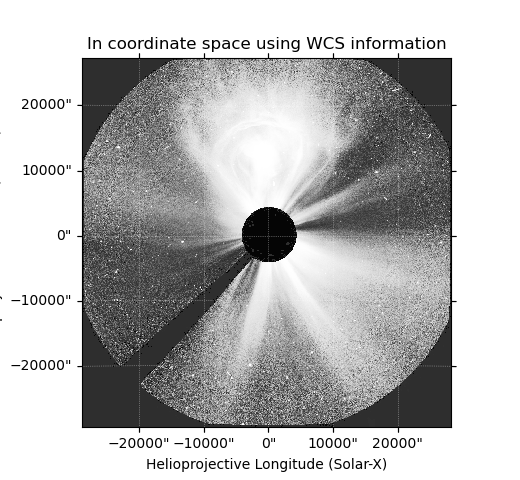
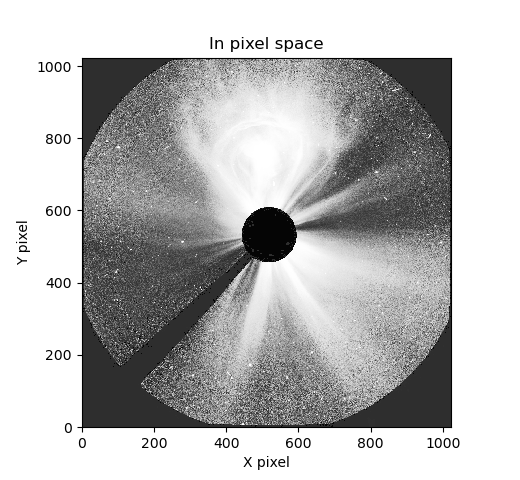
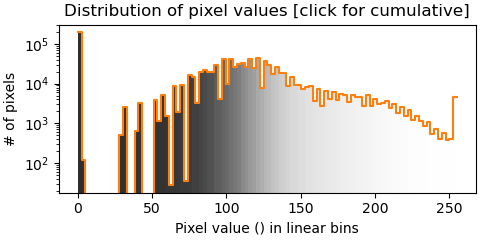
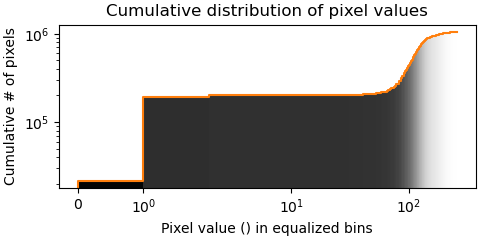

In [ ]:
lasco_map

A user warning let's you know that there is missing metadata for the observer
location. sunpy goes ahead and assumes that the observer is at Earth.

In [ ]:
print(lasco_map.observer_coordinate)

<SkyCoord (HeliographicStonyhurst: obstime=2000-02-27T07:42:05.810, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (0., -7.18539121, 0.99025198)>


To check that this worked let's get the location of Mercury in this exposure
and show that it is in the correct location.

In [ ]:
mercury_wrong = get_body_heliographic_stonyhurst(
    'mercury', lasco_map.date, observer=lasco_map.observer_coordinate)
mercury_hpc_wrong = mercury_wrong.transform_to(lasco_map.coordinate_frame)
print(mercury_hpc_wrong)

INFO: Apparent body location accounts for 330.72 seconds of light travel time [sunpy.coordinates.ephemeris]
<Helioprojective Coordinate (obstime=2000-02-27T07:42:05.810, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2000-02-27T07:42:05.810, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.18539121, 1.48139588e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-23270.04480977, 13370.17281802, 0.66275526)>


Let's plot how this looks with the incorrect observer information.

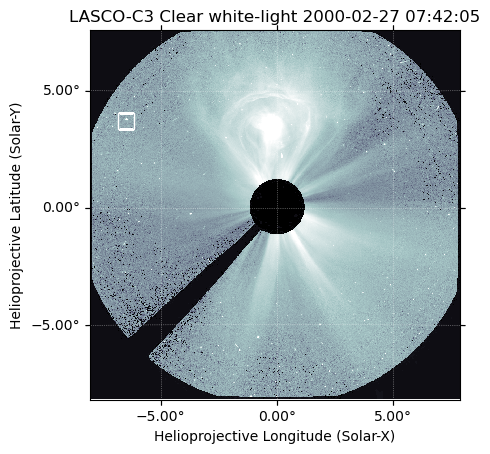

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=lasco_map)

# Let's tweak the axis to show in degrees instead of arcsec
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.plot_coord(mercury_hpc_wrong, 's', color='white',
              fillstyle='none', markersize=12, label='Mercury')
lasco_map.plot(axes=ax)

plt.show()

SOHO is actually a [halo orbit](https://en.wikipedia.org/wiki/Solar_and_Heliospheric_Observatory#Orbit)
around the Sun–Earth L1 point, about 1 million km away from the Earth.
The following functions queries JPL HORIZONS which includes positions of major spacecraft.
This function requires an internet connection to fetch the ephemeris data.

In [ ]:
soho = get_horizons_coord('SOHO', lasco_map.date)

INFO: Obtained JPL HORIZONS location for SOHO (spacecraft) (-21)         [sunpy.coordinates.ephemeris]


For fun, let's see how far away from the Earth SOHO is by converting to
an Earth-centered coordinate system (GCRS).

In [ ]:
print(soho.transform_to('gcrs').distance.to('km'))

1352064.9173251777 km


Let's fix the header.

In [ ]:
lasco_map.meta['HGLN_OBS'] = soho.lon.to('deg').value
lasco_map.meta['HGLT_OBS'] = soho.lat.to('deg').value
lasco_map.meta['DSUN_OBS'] = soho.radius.to('m').value

In [ ]:
lasco_map.observer_coordinate

<SkyCoord (HeliographicStonyhurst: obstime=2000-02-27T07:42:05.810, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.18152063, -7.15573287, 1.46871806e+11)>

Let's get the right position now.

In [ ]:
mercury = get_body_heliographic_stonyhurst(
    'mercury', lasco_map.date, observer=lasco_map.observer_coordinate)
mercury_hpc = mercury.transform_to(lasco_map.coordinate_frame)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Apparent body location accounts for 326.33 seconds of light travel time [sunpy.coordinates.ephemeris]


The difference between the incorrect position and the right one is:

In [ ]:
mercury_hpc

<Helioprojective Coordinate (obstime=2000-02-27T07:42:05.810, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2000-02-27T07:42:05.810, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.18539121, 1.48139588e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-23269.6177896, 13370.18375859, 0.6627545)>

In [ ]:
mercury_hpc_wrong

<Helioprojective Coordinate (obstime=2000-02-27T07:42:05.810, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2000-02-27T07:42:05.810, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -7.18539121, 1.48139588e+11)>): (Tx, Ty, distance) in (arcsec, arcsec, AU)
    (-23270.04480977, 13370.17281802, 0.66275526)>

In [ ]:
r = np.sqrt((mercury_hpc.Tx - mercury_hpc_wrong.Tx) ** 2 +
            (mercury_hpc.Ty - mercury_hpc_wrong.Ty) ** 2)
print(r)

0.42716030654385845 arcsec


Let's plot the results.

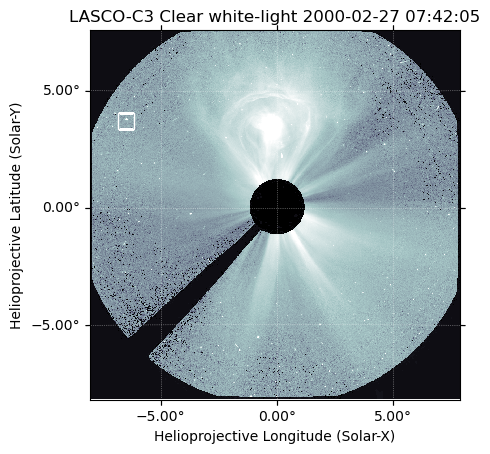

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=lasco_map)

# Let's tweak the axis to show in degrees instead of arcsec
lon, lat = ax.coords
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
ax.plot_coord(mercury_hpc, 's', color='white', fillstyle='none', markersize=12, label='Mercury')
lasco_map.plot(axes=ax)

plt.show()